# Cisco Live 2022 - DEVWKS-2150 - Predicting your office occupancy and environmental status using Cisco DNA Spaces and Machine Learning - 6 month dataset - ML models

by Flavio Correa - @correaflavio

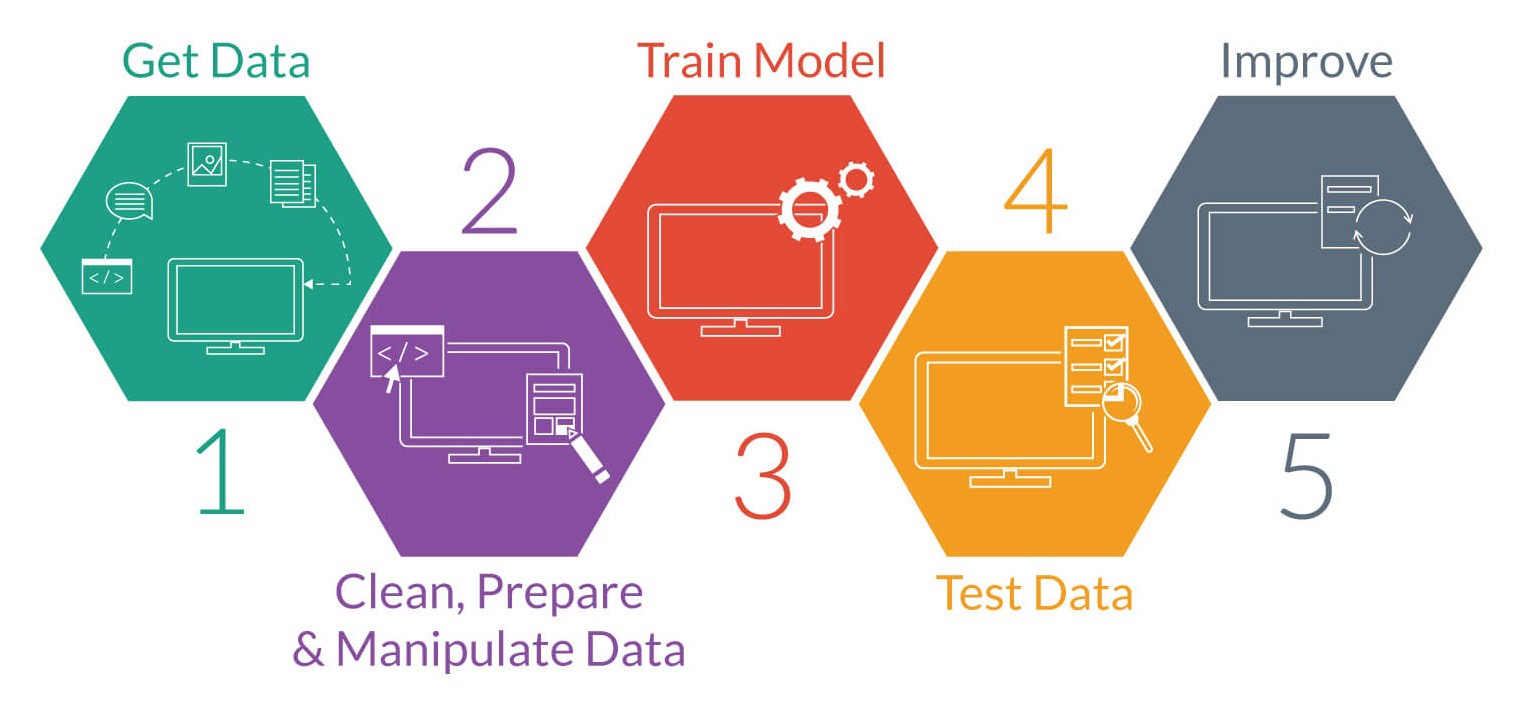

Image Source: https://towardsdatascience.com/wtf-is-machine-learning-a-quick-guide-39457e49c65b

<br>

# **0. Define what is your problem and how machine learning can help you.**

One of the most important things in Machine Learning is how you frame your problem, considering the capabilities of the different machine learning algorithms. Knowing what Machine Learning can and cannot do is critical.

One valid initial approach is to identify if your problem can be solved by a supervised learning (in case you have or can generate data with labels for training and testing) or if you will have to use unsupervised learning (no labels available so you can for instance try to group your data depending of their characteristics).

### **Supervised Learning**

For each input in the training data set, there will be an known output associated.

- **Classification**: assign groups to input data based on previous data

- **Regression**: predicts real values based on previous data

<br>


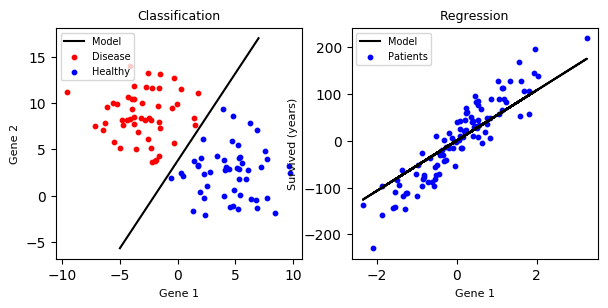

Image Source: https://dev.to/petercour/machine-learning-classification-vs-regression-1gn

### **Features and Labels**

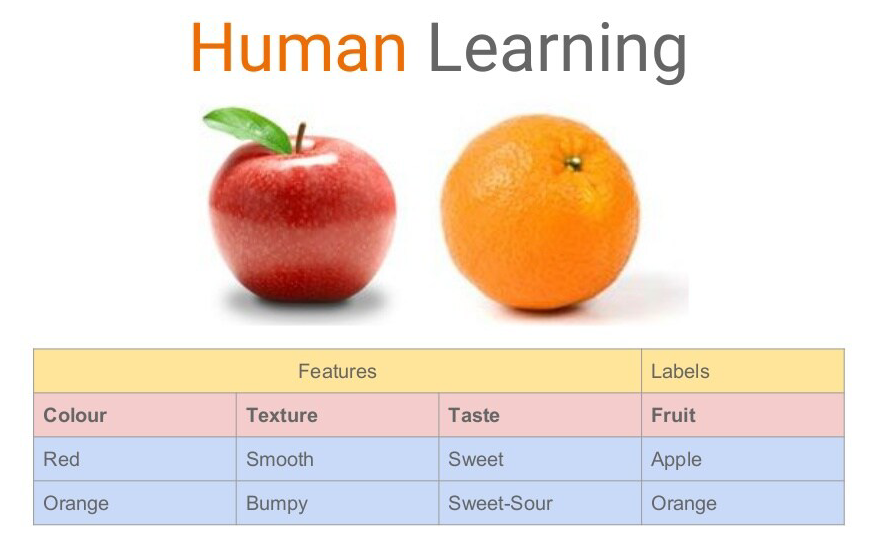

Image source: https://www.slideshare.net/lakshya90/machine-learning-workshop-84176551

### **Classification Example @ DEVWKS-1391**

In our DevNet session DEVWKS-1391 we've created our first Machine Learning models using Wi-Fi data to determine in **which room a person or object is located** using previous collected RSSI measurements. 
<br><br>



### **Regression Example**

Using regression instead of classification, we can calculate a value based in the features of the examples collected.

Also in this case, instead of looking the number of False Positives and False Negatives as the metric to evaluate the model accuracy, we compute the loss function of the data points versus the value predicted by model.


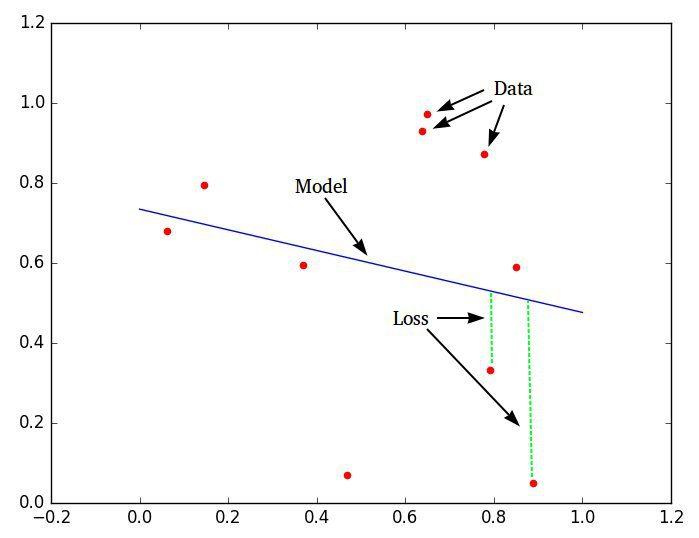

Image Source:https://www.kdnuggets.com/2017/06/regression-analysis-really-machine-learning.html 

This could be used in a lot of different scenarios like:

- We can use Wi-Fi and/or BLE RSSI measurements to build our on location algorithm based in the fingerprints collected.

- Predict the Throughput of a client based in observations made in the network looking RSSI, SNR, Tput of the client, together with AP data like number of clients, channel width, channel utilization and many others.

### **Time Series Forecasting**

When you have data that the sequence of it matters in the problem that you are trying to solve, that are specific methods that can be used when you considers your data a time series type.

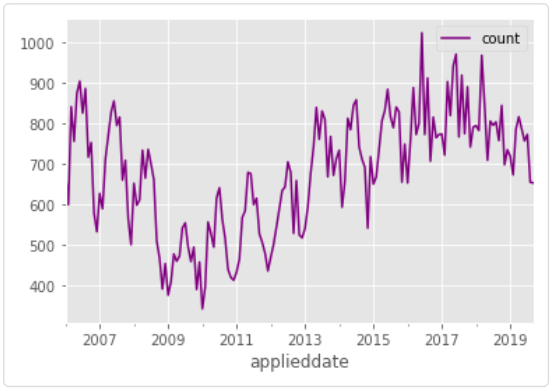

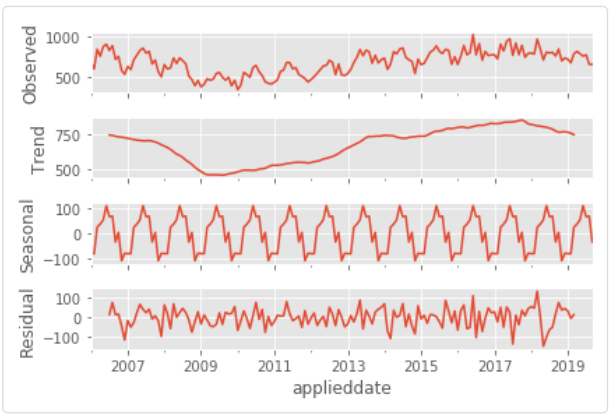

Image Source: https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

We have a lot of different use cases for time series analysis and forecasting, and this also applies to Wi-Fi related scenarios.

Here are some examples:

- Try to predict the number of employees that will be in the office based in the measurements that we are getting in the last days and weeks. The sazonality of the data is key to predict it since people may avoid to go to the office on Mondays and Fridays.

- Use channel plan information colleted during the days and weeks, to suggest a channel change or a different channel plan based in previous observations. Channels can change depending of interferers that may show up during the day.
<br><br>

In this exercise we will focus on predicting the office occupancy based in past data collected and try to answer the question **"do I have enough capacity in my offices to get employees and customers back?"**

<br><br>

### **Times Series Models**
<br>

- Traditional Time Series Models (statistical models): Univariate Models (ARIMA, SARIMAX, Prophet), Multivariate Models (Vector Autoregression)
<br>

- Machine Learning Models: Random Forest, Gradient Boost, Neural Networks (LTSM)
<br>

In this session today we will focus on ML regressors, instead of the the more traditional Statistical Models, and for that we will need to have special caution about how to handle and model the data.


Reference Link about traditional Time Series Models:

https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f



### These are the main python packages that we will use.
    
- **Pandas** - #pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- **Numpy** - NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more. 
- **Matplotlib** - Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- **Sklearn** - Simple and efficient tools for predictive data analysis. Accessible to everybody, and reusable in various contexts. #Built on NumPy, SciPy, and matplotlib · Open.
- **Graphviz** - This package facilitates the creation and rendering of graph descriptions in the DOT language of the Graphviz graph drawing software from Python.

In [104]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



---



---



# **1. Getting data to train your model**

## First you need is data. Sources of data for Wi-Fi related scenarios

- **Wireless LAN Controller Telemetry** - APs, clients, mobility, rrm, rogue, etc.
- **Location Services data** - number of visitors, devices, time of visit, number of visits, raw x/y data, etc. 
- **Wi-Fi and BLE IoT data** - temperature, pressure, humidity, CO2 level, PiR presence, etc.

## How to capture location occupancy and environmental data


First you need to **location occupancy data** from your network during a certain period of time. These will be your examples to train the model.

There are different ways that you can capture this information from your network. Since we are considering to use Wi-Fi data, one first way to estimate the ammount of people in a certain location is to use the number of users connected to your Wi-Fi network.

One issue with users connected metric, is that today users usually have multiple devices (at least a smartphone and a laptop) and if your counting the number of devices connected will have to factor it somehow.

In the other hand, maybe not 100% of the people will get connected to the network of the office, especially the employees doing activities that do not require internet access. Maybe you as a company don't give to contractors internet access and so on.

However if you think to consider all the devices detected (connected + probing), you will end up counting one device as dozen devices due to the very common Mac Randomization used by most of the smartphone vendors.

Here you have the options to collect the data:

- Meraki networks can get the number of devices connected using the Meraki APIs.

- Catalyst Wireless LAN controllers you can subscribe to the telemetry that provides this information.

- 3rd and most recommended one, is to get the occupancy data from Cisco DNA Spaces Firehose API. This is the most recommended one because DNAS will process the raw data and provide a high quality data via API, for instance eliminating duplicates based on user login. 

<br>

Let's consider for this exercise to use the Cisco DNA Spaces data, available via Firehose API.

There are different types of attributes or features that could be used. **For the location occupancy scenario we will focus on a per floor total number of employees, per day.**

The data series for this problem is basically the quantity of people in a particular location (room, floor or building) registered at a certain period of time. The interval used to collect this data can be adjusted, or the collected data summarized, but it's important to consider regular intervals for your model.

**Based in the data collected the initial feature is the time and the label is the number of employees. But we will also create new feature to handle it as a regression problem**

It's important to notice that this type of data series is called **time data series since the data is ordered in time** and to work with it we will need to take the order into the context.

Observation: If you try the statistical models, we need to guarantee that our data series is **stationary** or that the statistical properties do not change over time. There is a way to test it (i.e. Dickey-Fuller test) but this is beyond the scope of this lab.

Medium Article about Time Series Analysis: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775


### Getting data from DNA Spaces Firehose API: Getting Office Occupancy Data.

<br>

As mentioned already we will use the Cisco DNA Spaces Firehose API to collect the data needed to build our model. There are different events at DNAS. We will use the Device Count.

<br>

**DNA Spaces Firehose API supported events:** Device Entry, Device Exit, Profile Update, Location Information Change, Tele Presence, Device Location Update, App Activation, Account Admin Change, Keep Alive, Device Presence, User Presence, IoT Telemetry, IoT User Action, **Device Count**, Camera Count, Raw Camera Count, Network Telemetry, Location Anchor Update.

<br>

DNA Spaces Firehose API documentation: 

https://partners.dnaspaces.io/docs/v1/basic/c-cisco-dnaspaces-firehose-api.html#!g-dnas-partners-firehose-api.html

<br>

Interesting project to collect data and load it directly into MongoDB.

DNA Spaces Firehose API handler for MongoDB:

https://developer.cisco.com/codeexchange/github/repo/SimonLight001/DNASFirehose_MongoDB_Handler



<br>

In [105]:
#API response entry example for Device Count event
api_response = []

api_response = [
  {'deviceCounts': {'associatedCount': 11,
                  'associatedDelta': 0,
                  'estimatedCapacityPercentage': 50.0,
                  'estimatedDensity': 1.00016666666666666666,
                  'estimatedProbingCount': 72,
                  'location': {'inferredLocationTypes': ['FLOOR'],
                               'locationId': 'location-a83daf27',
                               'name': 'Floor A',
                               'parent': {'inferredLocationTypes': ['NETWORK',
                                                                    'BUILDING'],
                                          'locationId': 'location-82se4e2',
                                          'name': 'Tower A',
                                          'parent': {'inferredLocationTypes': ['CAMPUS'],
                                                     'locationId': 'location-2de61187',
                                                     'name': 'Campus A',
                                                     'parent': {'inferredLocationTypes': ['CMX'],
                                                                'locationId': 'location-2235341f',
                                                                'name': 'Cisco',
                                                                'parent': {'inferredLocationTypes': ['ROOT'],
                                                                           'locationId': 'location-a91624d7',
                                                                           'name': 'Cisco'}}}}},
                  'probingDelta': 5,
                  'probingRandomizedPercentage': 0.0},
 'eventType': 'DEVICE_COUNT',
 'partnerTenantId': '6392FBDC4AD24AA59203672D1312B22B',
 'recordTimestamp': 1651324360,
 'recordUid': 'event-26624538',
 'spacesTenantId': 'spaces-tenant-a39b126e',
 'spacesTenantName': 'Cisco'}
 
]

We will convert every telemetry entry into a python dictionary first and parse just the atributes that we want, to build a pandas dataframe that will be used in our ML model later.

When you get the data from the Firehose API you will get a list of dictionaries. We can parse the first example [0] and get the number of associated devices in this floor as our occupancy value. Also we will need the timestamp to know when this location had this quantity of devices associated.

We could use the capacity percentage instead of the absolute value of associated devices.

User count can be obtained via Webex Device counters for rooms, as well via Meraki Cameras, using the Tele Presence and the Camera Count events respectively.

In [106]:
#Device Count API dictionary
api_response[0]

{'deviceCounts': {'associatedCount': 11,
  'associatedDelta': 0,
  'estimatedCapacityPercentage': 50.0,
  'estimatedDensity': 1.0001666666666666,
  'estimatedProbingCount': 72,
  'location': {'inferredLocationTypes': ['FLOOR'],
   'locationId': 'location-a83daf27',
   'name': 'Floor A',
   'parent': {'inferredLocationTypes': ['NETWORK', 'BUILDING'],
    'locationId': 'location-82se4e2',
    'name': 'Tower A',
    'parent': {'inferredLocationTypes': ['CAMPUS'],
     'locationId': 'location-2de61187',
     'name': 'Campus A',
     'parent': {'inferredLocationTypes': ['CMX'],
      'locationId': 'location-2235341f',
      'name': 'Cisco',
      'parent': {'inferredLocationTypes': ['ROOT'],
       'locationId': 'location-a91624d7',
       'name': 'Cisco'}}}}},
  'probingDelta': 5,
  'probingRandomizedPercentage': 0.0},
 'eventType': 'DEVICE_COUNT',
 'partnerTenantId': '6392FBDC4AD24AA59203672D1312B22B',
 'recordTimestamp': 1651324360,
 'recordUid': 'event-26624538',
 'spacesTenantId': 'spa

# **2. Cleaning, manipulating and preparing the data**

### Parsing the data from JSON to a Dataframe & Selecting the features

One possibility to work with this data is to parse the data that we want into a new dictionary that will be converted later in an entry of the dataframe.

In [108]:
data = {}


Let's capture the location information of this telemetry event, going into the hierarchy.

In [110]:
#Floor name
floor = api_response[0]['deviceCounts']['location']['name']
print(floor)

#Add to the dictionary
data.update( {'floor': floor} )

Floor A


In [111]:
#Building name
building = api_response[0]['deviceCounts']['location']['parent']['name']
print(building)


#Add to the dictionary
data.update( {'building': building} )

Tower A


In [112]:
#Campus name
campus = api_response[0]['deviceCounts']['location']['parent']['parent']['name']
print(campus)

#Add to the dictionary
data.update( {'campus': campus} )

Campus A


Now let's extract the quantities of associated devices, capacity percentage and probing count

In [113]:
#Use the deviceCounts dictionary content
api_response[0]['deviceCounts']

{'associatedCount': 11,
 'associatedDelta': 0,
 'estimatedCapacityPercentage': 50.0,
 'estimatedDensity': 1.0001666666666666,
 'estimatedProbingCount': 72,
 'location': {'inferredLocationTypes': ['FLOOR'],
  'locationId': 'location-a83daf27',
  'name': 'Floor A',
  'parent': {'inferredLocationTypes': ['NETWORK', 'BUILDING'],
   'locationId': 'location-82se4e2',
   'name': 'Tower A',
   'parent': {'inferredLocationTypes': ['CAMPUS'],
    'locationId': 'location-2de61187',
    'name': 'Campus A',
    'parent': {'inferredLocationTypes': ['CMX'],
     'locationId': 'location-2235341f',
     'name': 'Cisco',
     'parent': {'inferredLocationTypes': ['ROOT'],
      'locationId': 'location-a91624d7',
      'name': 'Cisco'}}}}},
 'probingDelta': 5,
 'probingRandomizedPercentage': 0.0}

In [114]:
#Associated clientes parsing
associatedCount = api_response[0]['deviceCounts']['associatedCount']
print(associatedCount)

#Add to the dictionary
data.update( {'associatedCount': associatedCount} )

11


In [115]:
#Probing clientes parsing
estimatedProbingCount = api_response[0]['deviceCounts']['estimatedProbingCount']
print(estimatedProbingCount)

#Add to the dictionary
data.update( {'estimatedProbingCount': estimatedProbingCount} )

72


In [116]:
#Estimated Floor capacity percentage parsing
estimatedCapacityPercentage = api_response[0]['deviceCounts']['estimatedCapacityPercentage']
print(estimatedCapacityPercentage)

#Add to the dictionary
data.update( {'estimatedCapacityPercentage': estimatedCapacityPercentage} )

50.0


Now let's extract the time of this telemetry record.

In [118]:
#Timestamp of the telemetry event
epoch_time = api_response[0]['recordTimestamp']
print(epoch_time)

#Add to the dictionary
data.update( {'epoch_time': epoch_time} )

1651324360


The API used epoch in the time stamps. Epoch time known as POSIX time, Unix time, and Unix timestamp, indicates the number of seconds passed since 1st January 1970, excluding the leap seconds. The Unix time contains ten digits and can represent the all-time zone at once

For this example we will use one occupancy value per day, which is the higher value registered, since the objetive will be to predict the occupancy per day not per hour or week.

In [119]:
#Refence documentation about
#https://docs.python.org/3/library/datetime.html

# importing the datetime package  
import datetime

# using the datetime.fromtimestamp() function  
date_time = datetime.datetime.fromtimestamp( epoch_time )  
  
# printing the value  
print("Given epoch time:", epoch_time)  
print("Converted Datetime:", date_time )  

Given epoch time: 1651324360
Converted Datetime: 2022-04-30 10:12:40


In [120]:
# using datetime.fromtimestamp() function to convert epoch time into datetime object  
mytimestamp = datetime.datetime.fromtimestamp( epoch_time )  

# using strftime() function to convert  
datetime_str = mytimestamp.strftime( "%Y/%m/%d")  
  
# printing the values  
print("Given epoch time:", epoch_time)  
print("Converted datetime string:", datetime_str)  

#Add to the dictionary
data.update( {'date_time': datetime_str} )

Given epoch time: 1651324360
Converted datetime string: 2022/04/30


In [121]:
#Data dictionary result
data

{'floor': 'Floor A',
 'building': 'Tower A',
 'campus': 'Campus A',
 'associatedCount': 11,
 'estimatedProbingCount': 72,
 'estimatedCapacityPercentage': 50.0,
 'epoch_time': 1651324360,
 'date_time': '2022/04/30'}

In [122]:
import pandas as pd

data_df = pd.DataFrame.from_dict([data], orient='columns')
data_df

,floor,building,campus,associatedCount,estimatedProbingCount,estimatedCapacityPercentage,epoch_time,date_time
0,Floor A,Tower A,Campus A,11,72,50.0,1651324360,2022/04/30


In [123]:
type(data_df)

pandas.core.frame.DataFrame

Adding a new entry to the dataframe.

In [137]:
#New API entry

api_response = [
  {'deviceCounts': {'associatedCount': 15,
                  'associatedDelta': 0,
                  'estimatedCapacityPercentage': 75.0,
                  'estimatedDensity': 1.50016666666666666666,
                  'estimatedProbingCount': 107,
                  'location': {'inferredLocationTypes': ['FLOOR'],
                               'locationId': 'location-a83daf27',
                               'name': 'Floor A',
                               'parent': {'inferredLocationTypes': ['NETWORK',
                                                                    'BUILDING'],
                                          'locationId': 'location-82se4e2',
                                          'name': 'Tower A',
                                          'parent': {'inferredLocationTypes': ['CAMPUS'],
                                                     'locationId': 'location-2de61187',
                                                     'name': 'Campus A',
                                                     'parent': {'inferredLocationTypes': ['CMX'],
                                                                'locationId': 'location-2235341f',
                                                                'name': 'Cisco',
                                                                'parent': {'inferredLocationTypes': ['ROOT'],
                                                                           'locationId': 'location-a91624d7',
                                                                           'name': 'Cisco'}}}}},
                  'probingDelta': 5,
                  'probingRandomizedPercentage': 0.0},
 'eventType': 'DEVICE_COUNT',
 'partnerTenantId': '6392FBDC4AD24AA59203672D1312B22B',
 'recordTimestamp': 1651350860,
 'recordUid': 'event-26624538',
 'spacesTenantId': 'spaces-tenant-a39b126e',
 'spacesTenantName': 'Cisco'}
 
]

In [145]:
#Running the parsing
floor = api_response[0]['deviceCounts']['location']['name']
building = api_response[0]['deviceCounts']['location']['parent']['name']
campus = api_response[0]['deviceCounts']['location']['parent']['parent']['name']
associatedCount = api_response[0]['deviceCounts']['associatedCount']
estimatedProbingCount = api_response[0]['deviceCounts']['estimatedProbingCount']
estimatedCapacityPercentage = api_response[0]['deviceCounts']['estimatedCapacityPercentage']
epoch_time = api_response[0]['recordTimestamp']
date_time = datetime.datetime.fromtimestamp( epoch_time )
mytimestamp = datetime.datetime.fromtimestamp( epoch_time )  
datetime_str = mytimestamp.strftime( "%Y/%m/%d")  

data.update( {'floor': floor} )
data.update( {'building': building} )
data.update( {'campus': campus} )
data.update( {'associatedCount': associatedCount} )
data.update( {'estimatedProbingCount': estimatedProbingCount} )
data.update( {'estimatedCapacityPercentage': estimatedCapacityPercentage} )
data.update( {'epoch_time': epoch_time} )
data.update( {'date_time': datetime_str} )  

data

{'floor': 'Floor A',
 'building': 'Tower A',
 'campus': 'Campus A',
 'associatedCount': 15,
 'estimatedProbingCount': 107,
 'estimatedCapacityPercentage': 75.0,
 'epoch_time': 1651350860,
 'date_time': '2022/04/30'}

In [146]:
#Adding the new record to the dataframe
data_df = data_df.append([data], ignore_index=True)
data_df

,floor,building,campus,associatedCount,estimatedProbingCount,estimatedCapacityPercentage,epoch_time,date_time
0,Floor A,Tower A,Campus A,11,72,50.0,1651324360,2022/04/30
1,Floor A,Tower A,Campus A,15,107,75.0,1651410860,2022/05/01
2,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30
3,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30


### Preparing the final dataframe 


You have to prepare the final dataframe that will be used to train our machine learning model.

In this step you need to make sure you have a clean dataframe, without blank entries, with the attributes in the correct format, etc.

Select all the entries that are relative to the floor that you are working on.

In [147]:
data_df

,floor,building,campus,associatedCount,estimatedProbingCount,estimatedCapacityPercentage,epoch_time,date_time
0,Floor A,Tower A,Campus A,11,72,50.0,1651324360,2022/04/30
1,Floor A,Tower A,Campus A,15,107,75.0,1651410860,2022/05/01
2,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30
3,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30


In [148]:
#Select data just for the location desired
df_floor_A = data_df.loc[data_df['floor'] == 'Floor A']
df_floor_A

,floor,building,campus,associatedCount,estimatedProbingCount,estimatedCapacityPercentage,epoch_time,date_time
0,Floor A,Tower A,Campus A,11,72,50.0,1651324360,2022/04/30
1,Floor A,Tower A,Campus A,15,107,75.0,1651410860,2022/05/01
2,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30
3,Floor A,Tower A,Campus A,15,107,75.0,1651350860,2022/04/30


In [149]:
#Remove the columns that won't be used
df_floor_A = df_floor_A.drop(columns=['epoch_time','floor','building', 'campus', 'estimatedProbingCount', 'estimatedCapacityPercentage'])
df_floor_A

,associatedCount,date_time
0,11,2022/04/30
1,15,2022/05/01
2,15,2022/04/30
3,15,2022/04/30


By default DNA Spaces Firehose API provides updates every minute about the Device Count. One of the necessary tasks is to keep just the highest value per day.

In [153]:
#Keep just the max value per day - peak occupancy value
df_floor_A.groupby('date_time').max()

,associatedCount
date_time,
2022/04/30,15
2022/05/01,15


### Loading the full dataset generated and get to know the data


Now that we know how to collect and process the data, let's load a complete dataset to run our analysis and build a model to predict the office occupancy.

In [132]:
#importing libraries

#pandas is a fast, powerful, flexible and easy to use open source data analysis 
#and manipulation tool, built on top of the Python programming language. 
import pandas as pd

#NumPy offers comprehensive mathematical functions, random number generators, 
#linear algebra routines, Fourier transforms, and more.
import numpy as np

#Matplotlib is a comprehensive library for creating static, animated, and 
#interactive visualizations in Python.
import matplotlib.pyplot as plt
%matplotlib inline

#Setup the plot size
plt.rcParams['figure.figsize'] = [16,6]

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

In [133]:
dataset = pd.read_csv('data/office_employee_frequency-6months-data.csv', index_col='date', dayfirst=True, parse_dates=True)
dataset.shape # lines , columns

(168, 4)

In [134]:
dataset.head() #Visualize the first lines of the pandas dataset

,floor,building,campus,associatedCount
date,,,,
2021-10-01,Floor A,Tower A,Campus A,155
2021-10-02,Floor A,Tower A,Campus A,1
2021-10-04,Floor A,Tower A,Campus A,197
2021-10-05,Floor A,Tower A,Campus A,339
2021-10-06,Floor A,Tower A,Campus A,373


In [135]:
dataset = dataset.loc[dataset['floor'] == 'Floor A'] #filter by floor in case you have data from multiple locations
dataset = dataset.drop(columns=['floor','building', 'campus']) #remove te columns that don't add info to the model

In [136]:
dataset.head()

,associatedCount
date,
2021-10-01,155
2021-10-02,1
2021-10-04,197
2021-10-05,339
2021-10-06,373


In [30]:
#getting the first and last date of the dataset index
print('Start date:', dataset.index.min())
print('End date:', dataset.index.max())

Start date: 2021-10-01 00:00:00
End date: 2022-03-31 00:00:00


In [31]:
#Check if there is null data
dataset[dataset['associatedCount'].isnull()]

,associatedCount
date,


In [32]:
#Check if there is NaN (not available)
dataset[dataset['associatedCount'].isna()]

,associatedCount
date,


In [33]:
#Documentation - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

#Reindex of the dataset and filling the blank records with zero to be able to use the dataset
dataset_index = pd.date_range(start=dataset.index.min(), end=dataset.index.max(), freq='D')
dataset = dataset.reindex(dataset_index)
dataset.fillna(0,inplace=True)

In [34]:
dataset.index

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10',
               ...
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29',
               '2022-03-30', '2022-03-31'],
              dtype='datetime64[ns]', length=182, freq='D')

In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2021-10-01 to 2022-03-31
Freq: D
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   associatedCount  182 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


In [36]:
print('Number of examples available in the dataset:', dataset.shape[0])

Number of examples available in the dataset: 182


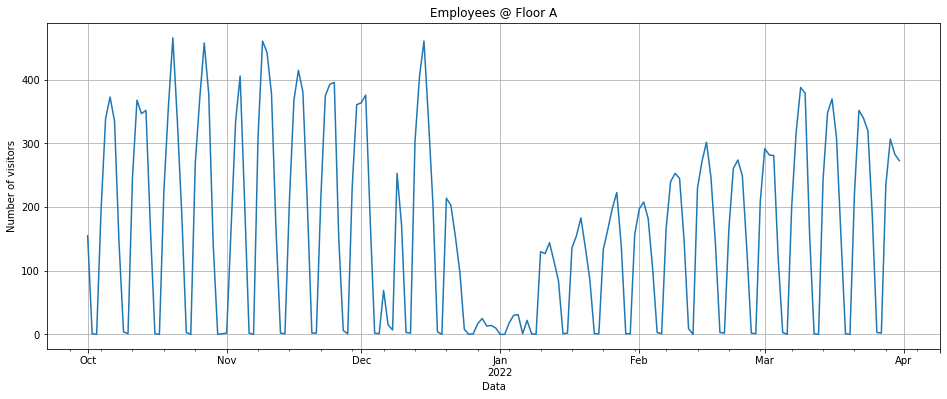

In [37]:
title = 'Employees @ Floor A'
ylabel = 'Number of visitors'
xlabel = 'Data'

ax=dataset['associatedCount'].plot(title=title);
ax.autoscale(axis='both');
ax.set(xlabel=xlabel,ylabel=ylabel);

ax.xaxis.grid(True) # grid on
ax.yaxis.grid(True)

### Feature Engineering

You could use just the date and number of employees registered with statistical models that capture trend and sazonality of your data automatically.
<br>

Here we will use instead a ML regressor model and for that we need to have features that describe our data and its relation with time. 

Below we will extract different attributes of the data: date components, rolling statistics and some lag information.

First consideration is that we want to predict the number of employees in the next day. This will be our target for the prediction. For that we will create a new feature which is the number of employees shifting back one day.

In [38]:
dataset['next_day_count'] = dataset['associatedCount'].shift(-1)

In [39]:
dataset.head()

,associatedCount,next_day_count
2021-10-01,155.0,1.0
2021-10-02,1.0,0.0
2021-10-03,0.0,197.0
2021-10-04,197.0,339.0
2021-10-05,339.0,373.0


Here we will extract the date components of our data, as features to be used by our model.

In [40]:
#Add the days of the week, month and quarter as variables trying to describe the seasonality

dataset['weekday'] = dataset.index.weekday #monday = 0 ... sunday = 6
dataset['week'] = dataset.index.week
dataset['month'] = dataset.index.month
dataset['quarter'] = dataset.index.quarter
dataset['year'] = dataset.index.year

In [41]:
dataset.head()

,associatedCount,next_day_count,weekday,week,month,quarter,year
2021-10-01,155.0,1.0,4,39,10,4,2021
2021-10-02,1.0,0.0,5,39,10,4,2021
2021-10-03,0.0,197.0,6,39,10,4,2021
2021-10-04,197.0,339.0,0,40,10,4,2021
2021-10-05,339.0,373.0,1,40,10,4,2021


Lets visualize the data generated.

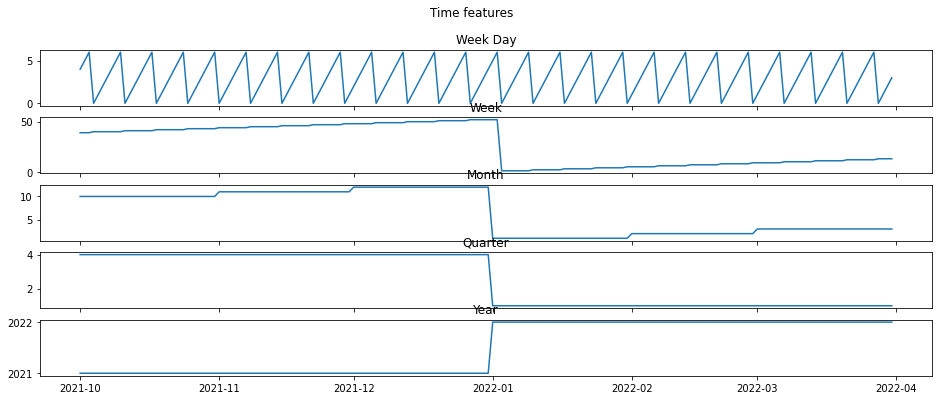

In [42]:
fig, axs = plt.subplots(5, sharex=True)
fig.suptitle('Time features')
axs[0].set_title('Week Day')
axs[1].set_title('Week')
axs[2].set_title('Month')
axs[3].set_title('Quarter')
axs[4].set_title('Year')

axs[0].plot(dataset['weekday'])
axs[1].plot(dataset['week'])
axs[2].plot(dataset['month'])
axs[3].plot(dataset['quarter'])
axs[4].plot(dataset['year'])

Also to capture some rolling statistics, or statistics over a period of time, to capture trending and sazonality information.

If the number of total visits in 7 days is increasing we have a positive trend and so on.

In [43]:
#Rolling sum with a window length of 7 observations.
dataset['associatedCount_7_day'] = dataset['associatedCount'].rolling(7).sum()

#Rolling sum with a window length of 30 observations.
dataset['associatedCount_30_day'] = dataset['associatedCount'].rolling(30).sum()

Lets visualize these rolling data generated.

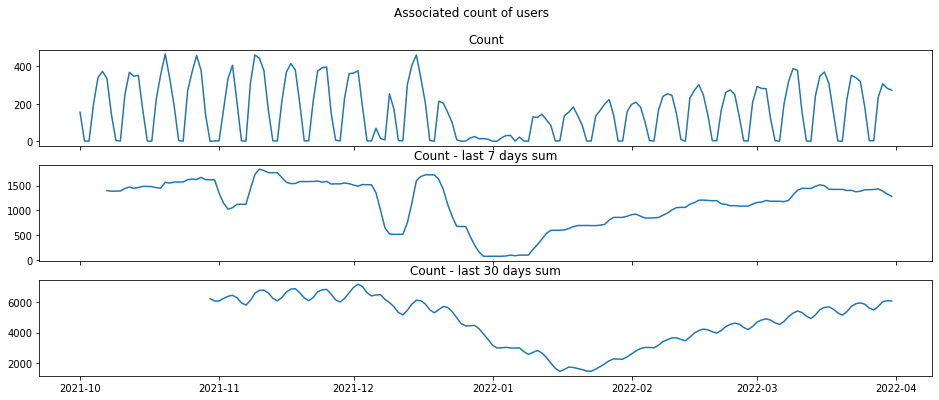

In [44]:
fig, axs = plt.subplots(3, sharex=True)
fig.suptitle('Associated count of users')
axs[0].set_title('Count')
axs[1].set_title('Count - last 7 days sum')
axs[2].set_title('Count - last 30 days sum')

axs[0].plot(dataset['associatedCount'])
axs[1].plot(dataset['associatedCount_7_day'])
axs[2].plot(dataset['associatedCount_30_day'])

Lets compute other rolling metrics.

In [45]:
#Rolling mean with a window length of 7 observations.
dataset['mean_7_day'] = dataset['associatedCount'].rolling(7).mean()

#Rolling mean with a window length of 30 observations.
dataset['mean_30_day'] = dataset['associatedCount'].rolling(30).mean()

#Difference between today and last day.
dataset['diff_1_day'] = dataset['associatedCount'].diff(1)

#Difference between lastday count and the sum of the last 7 days
dataset['diff_1_day_and_rolling_7'] = dataset['associatedCount'].rolling(7).sum() - dataset['associatedCount'].diff(1)


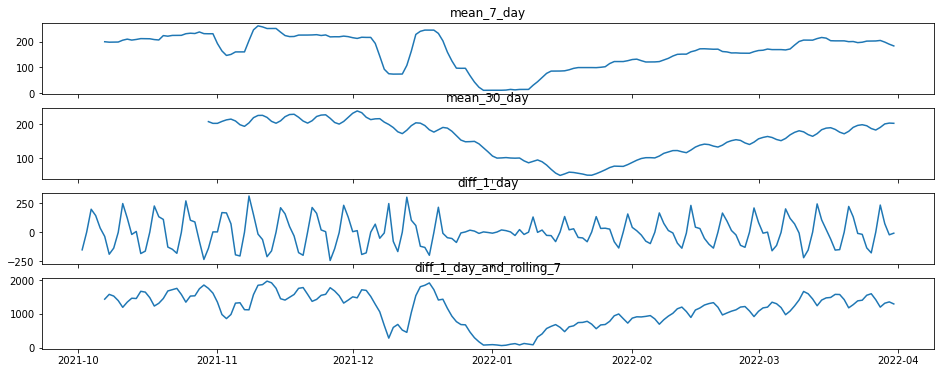

In [46]:
fig, axs = plt.subplots(4, sharex=True)
axs[0].set_title('mean_7_day')
axs[1].set_title('mean_30_day')
axs[2].set_title('diff_1_day')
axs[3].set_title('diff_1_day_and_rolling_7')

axs[0].plot(dataset['mean_7_day'])
axs[1].plot(dataset['mean_30_day'])
axs[2].plot(dataset['diff_1_day'])
axs[3].plot(dataset['diff_1_day_and_rolling_7'])

You can add more data to it like temperature (even captured by DNA Spaces sensor data), public holidays, etc. 

This is considered an exogenous feature which is a time series and are external, i.e. do not depend on the time series to be forecast. With Machine Learning models you can use exogenous features, with statistical models, most of it don't support it.

Most of the models can't have null entries. Because of that we will fill the NaN entries with zero. Another possibility is to discard the first 30 days of data, since the 30 days rolling sum has it's first value 30 days after the start.

In [47]:
dataset.fillna(0,inplace=True)
dataset.head(30)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2021-10-01,155.0,1.0,4,39,10,4,2021,0.0,0.0,0.000000,0.000000,0.0,0.0
2021-10-02,1.0,0.0,5,39,10,4,2021,0.0,0.0,0.000000,0.000000,-154.0,0.0
2021-10-03,0.0,197.0,6,39,10,4,2021,0.0,0.0,0.000000,0.000000,-1.0,0.0
2021-10-04,197.0,339.0,0,40,10,4,2021,0.0,0.0,0.000000,0.000000,197.0,0.0
2021-10-05,339.0,373.0,1,40,10,4,2021,0.0,0.0,0.000000,0.000000,142.0,0.0
2021-10-06,373.0,335.0,2,40,10,4,2021,0.0,0.0,0.000000,0.000000,34.0,0.0
2021-10-07,335.0,143.0,3,40,10,4,2021,1400.0,0.0,200.000000,0.000000,-38.0,1438.0
2021-10-08,143.0,4.0,4,40,10,4,2021,1388.0,0.0,198.285714,0.000000,-192.0,1580.0
2021-10-09,4.0,1.0,5,40,10,4,2021,1391.0,0.0,198.714286,0.000000,-139.0,1530.0
2021-10-10,1.0,247.0,6,40,10,4,2021,1392.0,0.0,198.857143,0.000000,-3.0,1395.0




---



---



##Splitting the dataset in training and test

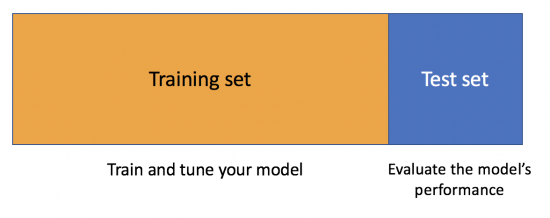

Source: https://docs.splunk.com/Documentation/ITSI/4.10.2/SI/TrainModel



---



---



###Split the data in train and test (-21 days)

In [48]:
split_len = len(dataset)-21
len(dataset),split_len, len(dataset)-split_len

(182, 161, 21)

In [49]:
train_dataset = dataset.iloc[:split_len]
test_dataset = dataset.iloc[split_len:]

In [50]:
dataset.tail()

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-27,2.0,235.0,6,12,3,1,2022,1421.0,5477.0,203.000000,182.566667,-1.0,1422.0
2022-03-28,235.0,307.0,0,13,3,1,2022,1435.0,5710.0,205.000000,190.333333,233.0,1202.0
2022-03-29,307.0,283.0,1,13,3,1,2022,1390.0,6016.0,198.571429,200.533333,72.0,1318.0
2022-03-30,283.0,273.0,2,13,3,1,2022,1333.0,6090.0,190.428571,203.000000,-24.0,1357.0
2022-03-31,273.0,0.0,3,13,3,1,2022,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0


In [51]:
features = ['mean_7_day','mean_30_day','diff_1_day','diff_1_day_and_rolling_7','associatedCount_7_day', 'associatedCount_30_day', 'weekday', 'week', 'month', 'quarter', 'year']
label = ['next_day_count']

In [52]:
X_train, y_train = train_dataset[features], train_dataset[label] 
X_train.shape, y_train.shape

((161, 11), (161, 1))

In [53]:
X_test, y_test = test_dataset[features], test_dataset[label] 
X_test.shape, y_test.shape

((21, 11), (21, 1))

# **3 & 4 Train and Test your model**

Let's start with the **Decision Tree (DT)** model which permits easy understanding of the logic used by the model trained. It will be our baseline model.

Decision Tree Article: https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14



**Mean Absolute Error (MAE)** is a model evaluation metric used with regression models. The mean absolute error of a model with respect to a test set is the mean of the absolute values of the individual prediction errors on over all instances in the test set.

Prediction Error = Actual value - Predicted Value

We should calculate this value for each row of data, then take the absolute value each, add them and finally compute the mean. The formula of MAE is:

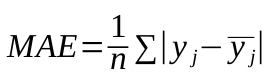

##Decision Tree Model (DT)

In [54]:
#sklearn - Simple and efficient tools for predictive data analysis · 
#Accessible to everybody, and reusable in various contexts · 
#Built on NumPy, SciPy, and matplotlib · Open

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


In [55]:
#Decision Tree model
model_dt = DecisionTreeRegressor(
    criterion="mae", # used to measure the split quality
    max_depth=3, # used to define the maximum depth of the tree
    random_state=42 # seed to have always the same results
 )

#Building the model using the method fit
#Use the training dataset to build the model
model_dt.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)

DecisionTreeRegressor(criterion='mae', max_depth=3, random_state=42)

<BarContainer object of 11 artists>

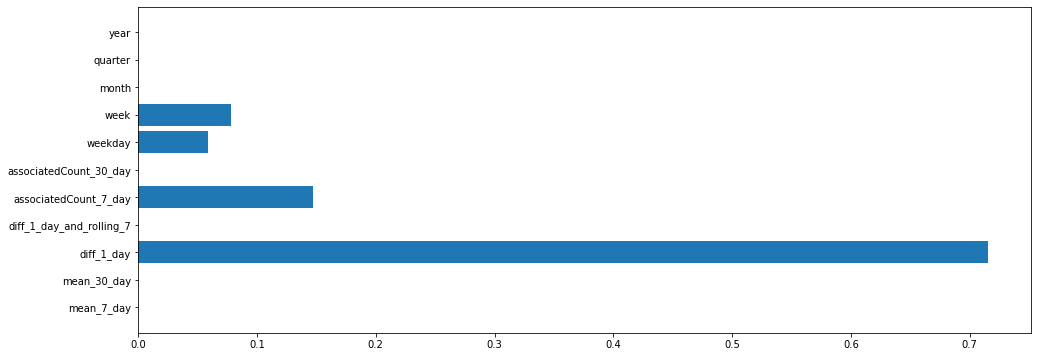

In [56]:
plt.barh(features, model_dt.feature_importances_)

In [57]:
predicted_DT = model_dt.predict(X_test)

test_dataset['DT'] = predicted_DT

from sklearn.metrics import mean_absolute_error
mae_dt = mean_absolute_error(test_dataset['next_day_count'],test_dataset['DT'])

print('DT MAE:',mae_dt)

DT MAE: 41.04761904761905


In [58]:
test_dataset.head()

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7,DT
2022-03-11,157.0,1.0,4,10,3,1,2022,1445.0,5316.0,206.428571,177.200000,-222.0,1667.0,2.0
2022-03-12,1.0,0.0,5,10,3,1,2022,1443.0,5072.0,206.142857,169.066667,-156.0,1599.0,1.0
2022-03-13,0.0,243.0,6,10,3,1,2022,1443.0,4923.0,206.142857,164.100000,-1.0,1444.0,198.0
2022-03-14,243.0,348.0,0,11,3,1,2022,1486.0,5157.0,212.285714,171.900000,243.0,1243.0,369.5
2022-03-15,348.0,370.0,1,11,3,1,2022,1516.0,5505.0,216.571429,183.500000,105.0,1411.0,369.5


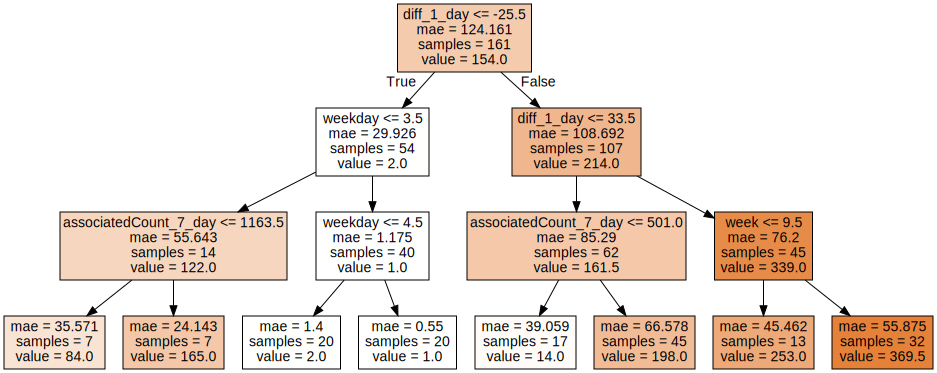

In [59]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(model_dt,
                                feature_names=features,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

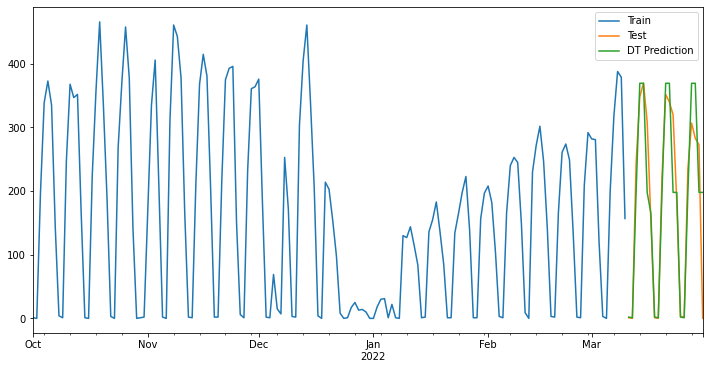

In [60]:
train_dataset['next_day_count'].plot(legend=True,label='Train',figsize=(12,6))
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['DT'].plot(legend=True,label='DT Prediction');

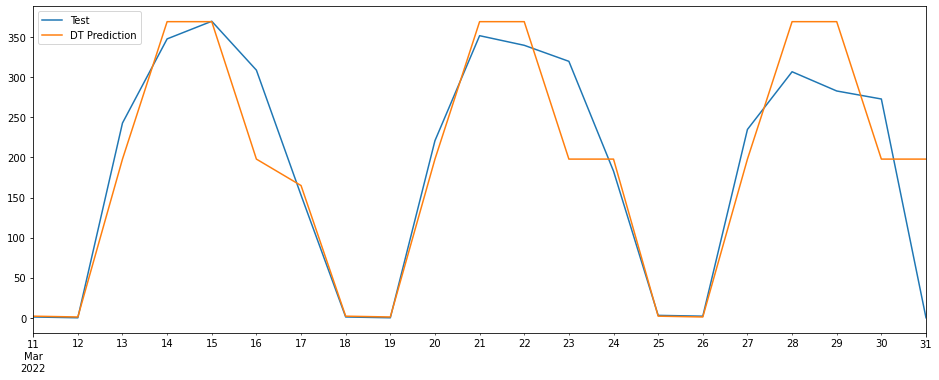

In [61]:
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['DT'].plot(legend=True,label='DT Prediction');

## Random Forest Model (RF)

In [62]:
#sklearn - Simple and efficient tools for predictive data analysis · 
#Accessible to everybody, and reusable in various contexts · 
#Built on NumPy, SciPy, and matplotlib · Open

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [63]:
#Decision Tree model
model_rf = RandomForestRegressor(
    n_estimators=100, #number of trees
    criterion="mae", # used to measure the split quality
    max_depth=10, # used to define the maximum depth of the tree
    random_state=42 # seed to have always the same results
 )

#Building the model using the method fit
#Use the training dataset to build the model
model_rf.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)

RandomForestRegressor(criterion='mae', max_depth=10, random_state=42)

<BarContainer object of 11 artists>

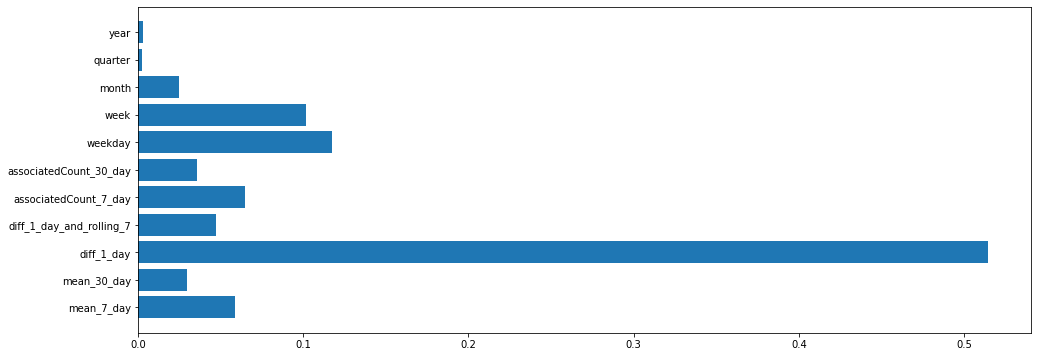

In [64]:
plt.barh(features, model_rf.feature_importances_)

In [65]:
predicted_RF = model_rf.predict(X_test)

test_dataset['RF'] = predicted_RF

mae_rf = mean_absolute_error(test_dataset['next_day_count'],test_dataset['RF'])

print('RF MAE:',mae_rf)

RF MAE: 33.57166666666667


In [66]:
test_dataset.head()

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7,DT,RF
2022-03-11,157.0,1.0,4,10,3,1,2022,1445.0,5316.0,206.428571,177.200000,-222.0,1667.0,2.0,2.370
2022-03-12,1.0,0.0,5,10,3,1,2022,1443.0,5072.0,206.142857,169.066667,-156.0,1599.0,1.0,1.030
2022-03-13,0.0,243.0,6,10,3,1,2022,1443.0,4923.0,206.142857,164.100000,-1.0,1444.0,198.0,187.985
2022-03-14,243.0,348.0,0,11,3,1,2022,1486.0,5157.0,212.285714,171.900000,243.0,1243.0,369.5,356.235
2022-03-15,348.0,370.0,1,11,3,1,2022,1516.0,5505.0,216.571429,183.500000,105.0,1411.0,369.5,362.840


In [67]:
#Trees generated, selecting one to be plotted
model_rf.estimators_[:4]

[DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                       max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                       max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                       max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                       max_features='auto', random_state=787846414)]

In [68]:
#Select tree 4 model
estimator = model_rf.estimators_[4]
estimator

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      max_features='auto', random_state=996406378)

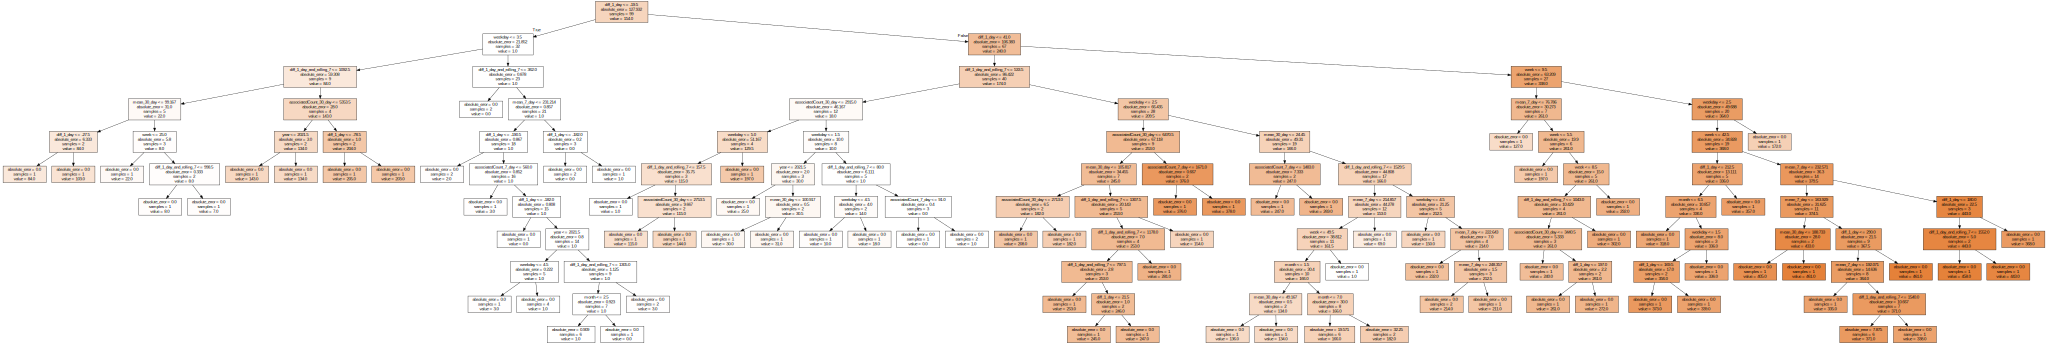

In [69]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(estimator,
                                feature_names=features,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [70]:
#Uncomment if you want to see all the 10 trees side by side. It takes couple of seconds.
#fig, axes = plt.subplots(nrows = 1,ncols = 10,figsize = (10,2), dpi=3000)
#for index in range(0, 10):
#    tree.plot_tree(model_rf.estimators_[index],
#                   feature_names = features, 
#                   filled = True,
#                   ax = axes[index]);
#    
#    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

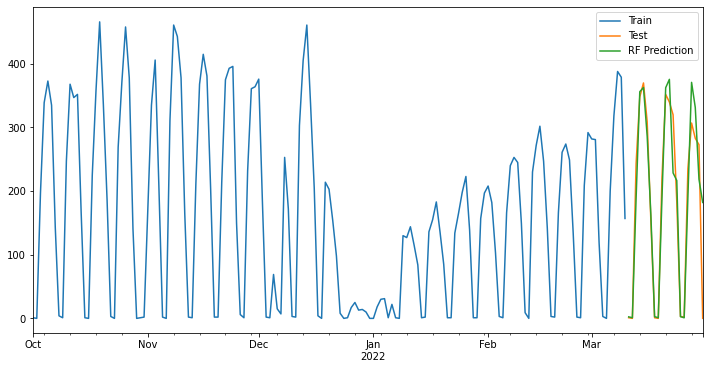

In [71]:
train_dataset['next_day_count'].plot(legend=True,label='Train',figsize=(12,6))
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['RF'].plot(legend=True,label='RF Prediction');

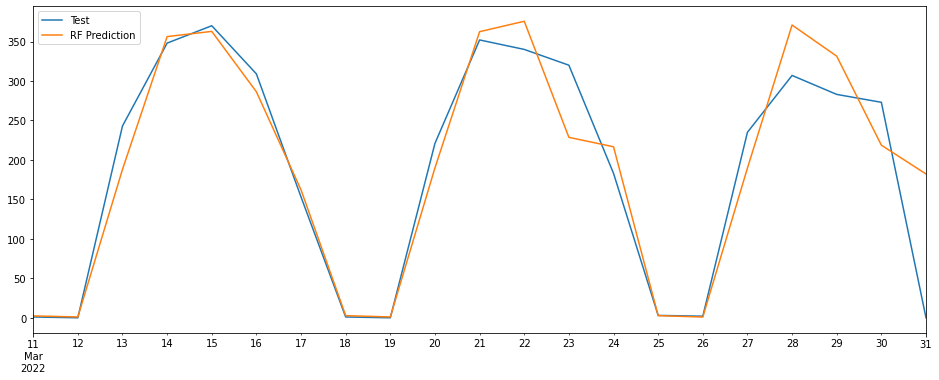

In [72]:
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['RF'].plot(legend=True,label='RF Prediction');

##Comparing Models

In [73]:
print('Mean Absolute Error (MAE) of the models: The lower the better')
print()
print('DT - MAE:',mae_dt)
print('RF - MAE:',mae_rf)

Mean Absolute Error (MAE) of the models: The lower the better

DT - MAE: 41.04761904761905
RF - MAE: 33.57166666666667


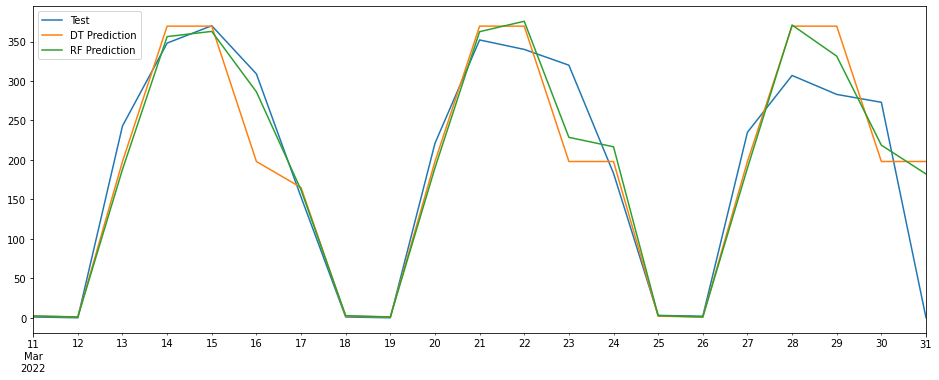

In [74]:
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['DT'].plot(legend=True,label='DT Prediction');
test_dataset['RF'].plot(legend=True,label='RF Prediction');

### My office will reach max capacity in the next 2 weeks?

Lets use the model with better accuracy to try to predict when the office will reach the max capacity.

There are different ways to approach this problem. We will use what is called a recursive strategy, where we will predict one step ahead and use the prediction to do the next and so on. 

This is a good article reference that talks about the different methods: exogenous features: exogenous features are themselves time series and are external, i.e. they do not depend on the time series to be forecast. In our case, an exogenous variable could be the external temperature. In this post, we do not consider them.

In [75]:
#Create a new dataset to be used for forecasting only, check last lines
df = dataset.copy()
df.tail()

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-27,2.0,235.0,6,12,3,1,2022,1421.0,5477.0,203.000000,182.566667,-1.0,1422.0
2022-03-28,235.0,307.0,0,13,3,1,2022,1435.0,5710.0,205.000000,190.333333,233.0,1202.0
2022-03-29,307.0,283.0,1,13,3,1,2022,1390.0,6016.0,198.571429,200.533333,72.0,1318.0
2022-03-30,283.0,273.0,2,13,3,1,2022,1333.0,6090.0,190.428571,203.000000,-24.0,1357.0
2022-03-31,273.0,0.0,3,13,3,1,2022,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0


In [76]:
#drop last row if needed
#df = df.iloc[:-1 , :]
#df.tail()

Use the model trained and the data from last day, to predict the next day number of employees.
The idea is that we can run the model at 00:00:01, righ after the statistics of the last day close, like the data below.

In [77]:
df.iloc[-1:] #data when closed the day at 00:00:01

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-31,273.0,0.0,3,13,3,1,2022,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0


In [78]:
#Using the model we can predict the max occupancy of the day that just started
pred = model_rf.predict(df.iloc[-1:][features])
next_day_count_pred = pred[0]
next_day_count_pred

182.165

In [79]:
#Imput the value of predicted employees for the day
df.loc[df.index[-1], 'next_day_count'] = next_day_count_pred
df.tail(3)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-29,307.0,283.000,1,13,3,1,2022,1390.0,6016.0,198.571429,200.533333,72.0,1318.0
2022-03-30,283.0,273.000,2,13,3,1,2022,1333.0,6090.0,190.428571,203.000000,-24.0,1357.0
2022-03-31,273.0,182.165,3,13,3,1,2022,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0


To the prediction not only for the next day, we can keep doing on step prediction, on top of the last prediction (also called recursive method).

In [80]:
#Calculated the date of the next day
next_date = df.index[-1] + pd.Timedelta(days=1)
next_date

Timestamp('2022-04-01 00:00:00', freq='D')

In [81]:
#Insert a new line to the dataframe with the next day
df = df.append(pd.DataFrame(index=[next_date]))
df.tail(2)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-31,273.0,182.165,3.0,13.0,3.0,1.0,2022.0,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0
2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
#Use last day predicted value as the "today's" value, since we don't have real measurement for future days.
last_day_count = df.loc[df.index[-2:-1], 'next_day_count'][0]
last_day_count

182.165

In [83]:
df.loc[df.index[-1], 'associatedCount'] = last_day_count
df.tail(1)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-04-01,182.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
#Calculate the time/date related features and insert on this new line
df.loc[df.index[-1], 'weekday'] = df.index[-1].weekday()
df.loc[df.index[-1], 'week'] = df.index[-1].week
df.loc[df.index[-1], 'month'] = df.index[-1].month
df.loc[df.index[-1], 'quarter'] = df.index[-1].quarter
df.loc[df.index[-1], 'year'] = df.index[-1].year

In [85]:
#Calculate the rolling features and insert on this new line
df.loc[df.index[-1], 'associatedCount_7_day'] = df.iloc[-7:]['associatedCount'].rolling(7).sum().values[-1]
df.loc[df.index[-1], 'associatedCount_30_day'] = df.iloc[-30:]['associatedCount'].rolling(30).sum().values[-1]

In [86]:
df.loc[df.index[-1], 'mean_7_day'] = df.iloc[-7:]['associatedCount'].rolling(7).mean().values[-1]
df.loc[df.index[-1], 'mean_30_day'] = df.iloc[-30:]['associatedCount'].rolling(30).mean().values[-1]
df.loc[df.index[-1], 'diff_1_day'] = df.iloc[-2:]['associatedCount'].diff(1).values[-1]
df.loc[df.index[-1], 'diff_1_day_and_rolling_7'] = df.iloc[-7:]['associatedCount'].rolling(7).mean().values[-1] - df.iloc[-2:]['associatedCount'].diff(1).values[-1]

In [87]:
#Visualize the last line and the new line inserted
df.tail(2)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-31,273.000,182.165,3.0,13.0,3.0,1.0,2022.0,1286.000,6071.000,183.714286,202.366667,-10.000,1296.00
2022-04-01,182.165,NaN,4.0,13.0,4.0,2.0,2022.0,1285.165,5971.165,183.595000,199.038833,-90.835,274.43



---



Since we want to predict what will be the office occupancy in the next few days, lets run it as a function for a forecast day period.

In [88]:
def future_office_occupancy(df, model, days):
  i = 0
  while i < days:
    
    pred = model_rf.predict(df.iloc[-1:][features])
    next_day_count_pred = pred[0]
    df.loc[df.index[-1], 'next_day_count'] = next_day_count_pred
    
    next_date = df.index[-1] + pd.Timedelta(days=1)
    df = df.append(pd.DataFrame(index=[next_date]))
    last_day_count = df.loc[df.index[-2:-1], 'next_day_count'][0]
    df.loc[df.index[-1], 'associatedCount'] = last_day_count
    
    df.loc[df.index[-1], 'weekday'] = df.index[-1].weekday()
    df.loc[df.index[-1], 'week'] = df.index[-1].week
    df.loc[df.index[-1], 'month'] = df.index[-1].month
    df.loc[df.index[-1], 'quarter'] = df.index[-1].quarter
    df.loc[df.index[-1], 'year'] = df.index[-1].year

    df.loc[df.index[-1], 'associatedCount_7_day'] = df.iloc[-7:]['associatedCount'].rolling(7).sum().values[-1]
    df.loc[df.index[-1], 'associatedCount_30_day'] = df.iloc[-30:]['associatedCount'].rolling(30).sum().values[-1]

    df.loc[df.index[-1], 'mean_7_day'] = df.iloc[-7:]['associatedCount'].rolling(7).mean().values[-1]
    df.loc[df.index[-1], 'mean_30_day'] = df.iloc[-30:]['associatedCount'].rolling(30).mean().values[-1]
    df.loc[df.index[-1], 'diff_1_day'] = df.iloc[-2:]['associatedCount'].diff(1).values[-1]
    df.loc[df.index[-1], 'diff_1_day_and_rolling_7'] = df.iloc[-7:]['associatedCount'].rolling(7).mean().values[-1] - df.iloc[-2:]['associatedCount'].diff(1).values[-1]


    i += 1
    
  return df 

In [89]:
#lets create a new dataframe just for that.
df = dataset.copy()
df.tail()

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-03-27,2.0,235.0,6,12,3,1,2022,1421.0,5477.0,203.000000,182.566667,-1.0,1422.0
2022-03-28,235.0,307.0,0,13,3,1,2022,1435.0,5710.0,205.000000,190.333333,233.0,1202.0
2022-03-29,307.0,283.0,1,13,3,1,2022,1390.0,6016.0,198.571429,200.533333,72.0,1318.0
2022-03-30,283.0,273.0,2,13,3,1,2022,1333.0,6090.0,190.428571,203.000000,-24.0,1357.0
2022-03-31,273.0,0.0,3,13,3,1,2022,1286.0,6071.0,183.714286,202.366667,-10.0,1296.0


In [90]:
forecast_days = 14
df_new = future_office_occupancy(df, model_rf, forecast_days)
#df_new = future_office_occupancy(df, model_dt, forecast_days)


In [91]:
df_new.tail(14)

,associatedCount,next_day_count,weekday,week,month,quarter,year,associatedCount_7_day,associatedCount_30_day,mean_7_day,mean_30_day,diff_1_day,diff_1_day_and_rolling_7
2022-04-01,182.165,2.885,4.0,13.0,4.0,2.0,2022.0,1285.165,5971.165,183.595000,199.038833,-90.835,274.430000
2022-04-02,2.885,0.920,5.0,13.0,4.0,2.0,2022.0,1285.050,5693.050,183.578571,189.768333,-179.280,362.858571
2022-04-03,0.920,200.595,6.0,13.0,4.0,2.0,2022.0,1283.970,5574.970,183.424286,185.832333,-1.965,185.389286
2022-04-04,200.595,353.790,0.0,14.0,4.0,2.0,2022.0,1249.565,5772.565,178.509286,192.418833,199.675,-21.165714
2022-04-05,353.790,362.475,1.0,14.0,4.0,2.0,2022.0,1296.355,6126.355,185.193571,204.211833,153.195,31.998571
2022-04-06,362.475,188.215,2.0,14.0,4.0,2.0,2022.0,1375.830,6288.830,196.547143,209.627667,8.685,187.862143
2022-04-07,188.215,125.970,3.0,14.0,4.0,2.0,2022.0,1291.045,6159.045,184.435000,205.301500,-174.260,358.695000
2022-04-08,125.970,12.795,4.0,14.0,4.0,2.0,2022.0,1234.850,5897.015,176.407143,196.567167,-62.245,238.652143
2022-04-09,12.795,0.950,5.0,14.0,4.0,2.0,2022.0,1244.760,5530.810,177.822857,184.360333,-113.175,290.997857
2022-04-10,0.950,158.280,6.0,14.0,4.0,2.0,2022.0,1244.790,5374.760,177.827143,179.158667,-11.845,189.672143


In [92]:
df_new.fillna(0, inplace=True)
ymax = df_new['next_day_count'][-(forecast_days):].values.max() #max occupancy registered
ymax

362.475

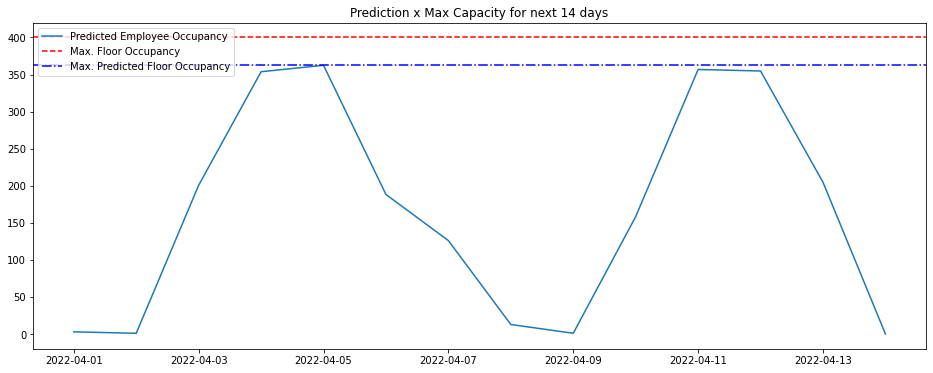

In [93]:
plt.plot(df_new['next_day_count'][-(forecast_days):], label = 'Predicted Employee Occupancy')

plt.axhline(y=400, color = "r", ls='--', label = "Max. Floor Occupancy")
plt.axhline(y=ymax, color = "b", ls='-.', label = "Max. Predicted Floor Occupancy")

plt.title('Prediction x Max Capacity for next ' + str(forecast_days) + ' days' )
plt.legend()
plt.show()



---



---



# **Next Steps**

##This is just the beginning!! Today we have limited time but here you have more ideas to explore!

There are many more possible examples about how you can start using ML in your Wi-Fi projects and operations.

Here are some other examples that we won't have time to go over today together!

##I hope you enjoyed and will have fun combining Wi-Fi and ML!



---



---



---



---



## Bonus model (optional): XGBoost Model (XGB)

In [94]:
#https://xgboost.readthedocs.io/en/stable/python/python_intro.html
import xgboost as xgb

In [95]:
model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01)
model_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:157.55496	validation_1-mae:185.83666
[1]	validation_0-mae:156.12236	validation_1-mae:184.18393
[2]	validation_0-mae:154.71315	validation_1-mae:182.59853
[3]	validation_0-mae:153.32333	validation_1-mae:181.01761
[4]	validation_0-mae:151.94710	validation_1-mae:179.41225
[5]	validation_0-mae:150.60663	validation_1-mae:177.79962
[6]	validation_0-mae:149.27893	validation_1-mae:176.20215
[7]	validation_0-mae:147.95540	validation_1-mae:174.64175
[8]	validation_0-mae:146.65280	validation_1-mae:173.07437
[9]	validation_0-mae:145.36999	validation_1-mae:171.48965
[10]	validation_0-mae:144.09534	validation_1-mae:169.91994
[11]	validation_0-mae:142.82051	validation_1-mae:168.41717
[12]	validation_0-mae:141.57245	validation_1-mae:166.87660
[13]	validation_0-mae:140.33609	validation_1-mae:165.35056
[14]	validation_0-mae:139.09627	validation_1-mae:163.88957
[15]	validation_0-mae:137.86105	validation_1-mae:162.33841
[16]	validation_0-mae:136.63652	validation_1-mae:160.80171
[17]	va

[142]	validation_0-mae:45.82327	validation_1-mae:53.49426
[143]	validation_0-mae:45.41558	validation_1-mae:53.07749
[144]	validation_0-mae:45.01108	validation_1-mae:52.67271
[145]	validation_0-mae:44.60891	validation_1-mae:52.22427
[146]	validation_0-mae:44.21022	validation_1-mae:51.82223
[147]	validation_0-mae:43.81183	validation_1-mae:51.41146
[148]	validation_0-mae:43.42230	validation_1-mae:51.01323
[149]	validation_0-mae:43.03345	validation_1-mae:50.57879
[150]	validation_0-mae:42.65352	validation_1-mae:50.21084
[151]	validation_0-mae:42.27516	validation_1-mae:49.84948
[152]	validation_0-mae:41.90112	validation_1-mae:49.44591
[153]	validation_0-mae:41.53141	validation_1-mae:49.08828
[154]	validation_0-mae:41.15914	validation_1-mae:48.68180
[155]	validation_0-mae:40.79260	validation_1-mae:48.31618
[156]	validation_0-mae:40.43102	validation_1-mae:47.98134
[157]	validation_0-mae:40.07075	validation_1-mae:47.71620
[158]	validation_0-mae:39.71320	validation_1-mae:47.40233
[159]	validati

[284]	validation_0-mae:14.77143	validation_1-mae:34.47512
[285]	validation_0-mae:14.67289	validation_1-mae:34.46200
[286]	validation_0-mae:14.57116	validation_1-mae:34.46508
[287]	validation_0-mae:14.47010	validation_1-mae:34.46830
[288]	validation_0-mae:14.37011	validation_1-mae:34.47159
[289]	validation_0-mae:14.27047	validation_1-mae:34.47476
[290]	validation_0-mae:14.17184	validation_1-mae:34.47837
[291]	validation_0-mae:14.07403	validation_1-mae:34.48158
[292]	validation_0-mae:13.97752	validation_1-mae:34.48466
[293]	validation_0-mae:13.88101	validation_1-mae:34.48772
[294]	validation_0-mae:13.78767	validation_1-mae:34.46249
[295]	validation_0-mae:13.69068	validation_1-mae:34.44267
[296]	validation_0-mae:13.59586	validation_1-mae:34.43308
[297]	validation_0-mae:13.50459	validation_1-mae:34.41765
[298]	validation_0-mae:13.41607	validation_1-mae:34.41707
[299]	validation_0-mae:13.33212	validation_1-mae:34.41636
[300]	validation_0-mae:13.24122	validation_1-mae:34.41971
[301]	validati

[427]	validation_0-mae:6.34875	validation_1-mae:33.68881
[428]	validation_0-mae:6.31471	validation_1-mae:33.67869
[429]	validation_0-mae:6.28671	validation_1-mae:33.69302
[430]	validation_0-mae:6.25904	validation_1-mae:33.69456
[431]	validation_0-mae:6.22545	validation_1-mae:33.70341
[432]	validation_0-mae:6.19814	validation_1-mae:33.71754
[433]	validation_0-mae:6.17118	validation_1-mae:33.73393
[434]	validation_0-mae:6.13861	validation_1-mae:33.74257
[435]	validation_0-mae:6.11094	validation_1-mae:33.74339
[436]	validation_0-mae:6.08603	validation_1-mae:33.75954
[437]	validation_0-mae:6.06111	validation_1-mae:33.77323
[438]	validation_0-mae:6.02976	validation_1-mae:33.78604
[439]	validation_0-mae:6.00512	validation_1-mae:33.80206
[440]	validation_0-mae:5.97311	validation_1-mae:33.77530
[441]	validation_0-mae:5.94899	validation_1-mae:33.78873
[442]	validation_0-mae:5.92420	validation_1-mae:33.80427
[443]	validation_0-mae:5.89427	validation_1-mae:33.81988
[444]	validation_0-mae:5.86940	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [96]:
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<BarContainer object of 11 artists>

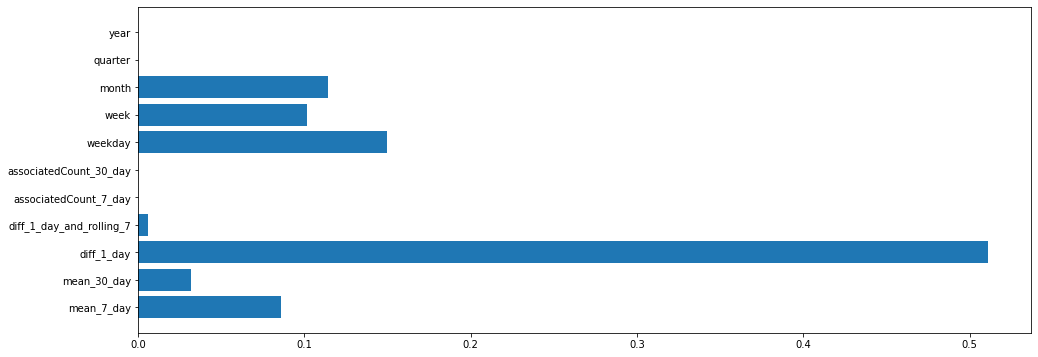

In [97]:
plt.barh(features, model_xgb.feature_importances_)

In [98]:
#!pip install graphviz

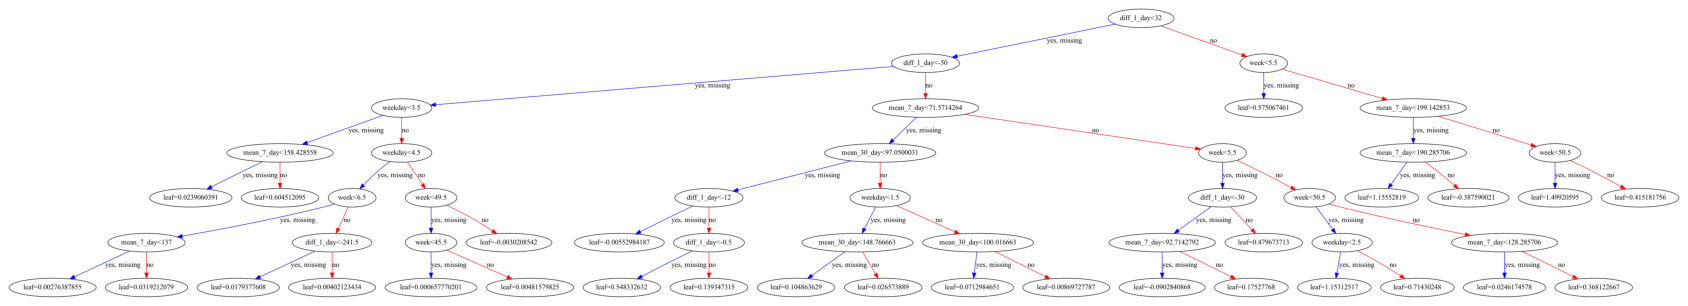

In [99]:
from xgboost import plot_tree
plot_tree(model_xgb, num_trees=100)
fig = plt.gcf()
fig.set_size_inches(30, 15)

In [100]:
predicted_XGB = model_xgb.predict(X_test)

test_dataset['XGB'] = predicted_XGB

from sklearn.metrics import mean_absolute_error
mae_xgb = mean_absolute_error(test_dataset['next_day_count'],test_dataset['XGB'])

print('XGB MAE:',mae_xgb)

XGB MAE: 34.78441814581553


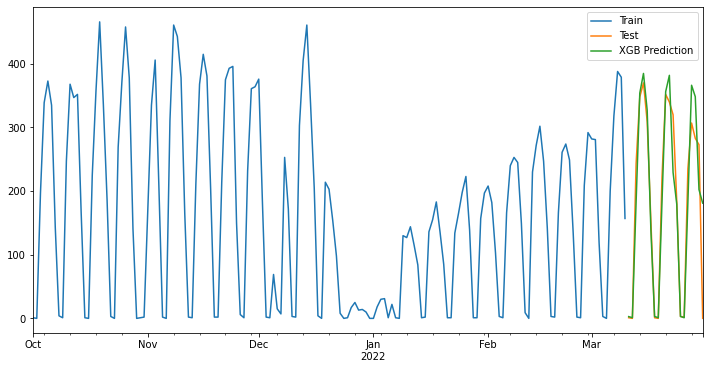

In [101]:
train_dataset['next_day_count'].plot(legend=True,label='Train',figsize=(12,6))
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['XGB'].plot(legend=True,label='XGB Prediction');

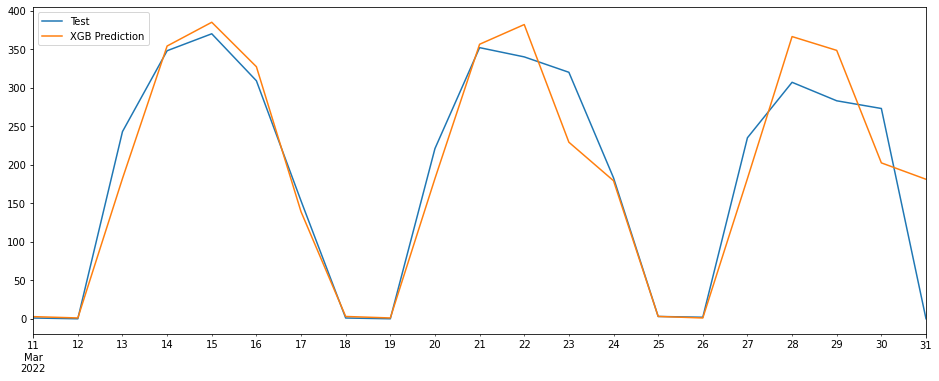

In [102]:
test_dataset['next_day_count'].plot(legend=True,label='Test')
test_dataset['XGB'].plot(legend=True,label='XGB Prediction');



---





---



---

